# Alphalens and Pyfolio integration

Alphalens can simulate the performance of a portfolio where the factor values are use to weight stocks. Once the portfolio is built, it can be analyzed by Pyfolio. For details on how this portfolio is built see:
- alphalens.performance.factor_returns
- alphalens.performance.cumulative_returns 
- alphalens.performance.create_pyfolio_input

In [ ]:
%pylab inline --no-import-all
import alphalens
import pyfolio
import pandas as pd
import numpy as np
import datetime

First load some stocks data

In [2]:
tickers = [ 'ACN', 'ATVI', 'ADBE', 'AMD', 'AKAM', 'ADS', 'GOOGL', 'GOOG', 'APH', 'ADI', 'ANSS', 'AAPL',
'AVGO', 'CA', 'CDNS', 'CSCO', 'CTXS', 'CTSH', 'GLW', 'CSRA', 'DXC', 'EBAY', 'EA', 'FFIV', 'FB',
'FLIR', 'IT', 'GPN', 'HRS', 'HPE', 'HPQ', 'INTC', 'IBM', 'INTU', 'JNPR', 'KLAC', 'LRCX', 'MA', 'MCHP',
'MSFT', 'MSI', 'NTAP', 'NFLX', 'NVDA', 'ORCL', 'PAYX', 'PYPL', 'QRVO', 'QCOM', 'RHT', 'CRM', 'STX',
'AMG', 'AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG', 'AIZ', 'BAC', 'BK', 'BBT', 'BRK.B', 'BLK', 'HRB',
'BHF', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'ETFC', 'RE', 'FITB', 'BEN',
'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JPM', 'KEY', 'LUK', 'LNC', 'L', 'MTB', 'MMC', 'MET', 'MCO', 'MS',
'NDAQ', 'NAVI', 'NTRS', 'PBCT', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'STI', 'SYF', 'TROW',
'ABT', 'ABBV', 'AET', 'A', 'ALXN', 'ALGN', 'AGN', 'ABC', 'AMGN', 'ANTM', 'BCR', 'BAX', 'BDX', 'BIIB', 'BSX',
'BMY', 'CAH', 'CELG', 'CNC', 'CERN', 'CI', 'COO', 'DHR', 'DVA', 'XRAY', 'EW', 'EVHC', 'ESRX', 'GILD', 'HCA',
'HSIC', 'HOLX', 'HUM', 'IDXX', 'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'LLY', 'MCK', 'MDT', 'MRK', 'MTD',
'MYL', 'PDCO', 'PKI', 'PRGO', 'PFE', 'DGX', 'REGN', 'RMD', 'SYK', 'TMO', 'UNH', 'UHS', 'VAR', 'VRTX', 'WAT',
'MMM', 'AYI', 'ALK', 'ALLE', 'AAL', 'AME', 'AOS', 'ARNC', 'BA', 'CHRW', 'CAT', 'CTAS', 'CSX', 'CMI', 'DE',
'DAL', 'DOV', 'ETN', 'EMR', 'EFX', 'EXPD', 'FAST', 'FDX', 'FLS', 'FLR', 'FTV', 'FBHS', 'GD', 'GE', 'GWW',
'HON', 'INFO', 'ITW', 'IR', 'JEC', 'JBHT', 'JCI', 'KSU', 'LLL', 'LMT', 'MAS', 'NLSN', 'NSC', 'NOC', 'PCAR',
'PH', 'PNR', 'PWR', 'RTN', 'RSG', 'RHI', 'ROK', 'COL', 'ROP', 'LUV', 'SRCL', 'TXT', 'TDG', 'UNP', 'UAL',
'AES', 'LNT', 'AEE', 'AEP', 'AWK', 'CNP', 'CMS', 'ED', 'D', 'DTE', 'DUK', 'EIX', 'ETR', 'ES', 'EXC']

In [ ]:
import pandas_datareader.data as web
pan = web.DataReader(tickers, "google", datetime.datetime(2015, 1, 1),  datetime.datetime(2017, 1, 1))

In [4]:
pan = pan.transpose(2,1,0)

We'll compute a simple mean reversion factor looking at recent stocks performance: stocks that performed well in the last 5 days will have high rank and vice versa.

In [5]:
factor = pan.loc[:,:,'Open']
factor = -factor.pct_change(5)

factor = factor.stack()
factor.index = factor.index.set_names(['date', 'asset'])

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestats will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, before the trading starts every day, we observe yesterday factor values. The price we pass to alphalens is the next available price after that factor observation: the daily open price that will be used as assets entry price. Also, we are not adding additional prices so the assets exit price will be the following days open prices (how many days depends on 'periods' argument). The retuns computed by Alphalens will therefore based on assets open prices.

In [6]:
pricing = pan.loc[:,:,'Open'].iloc[1:]

# Prepare data and run Alphalens

Pyfolio wants timezone set to UTC otherwise it refuses to work

In [7]:
pricing.index = pricing.index.tz_localize('UTC')

In [8]:
factor = factor.unstack()
factor.index = factor.index.tz_localize('UTC')
factor = factor.stack()

In [9]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   pricing,
                                                                   periods=(1, 3, 5),
                                                                   quantiles=5,
                                                                   bins=None)

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-63.109756,0.075731,-0.044736,0.410758,24032,20.210923
2,-0.113547,0.096591,-0.013790,0.020938,23681,19.915732
3,-0.080349,0.110527,-0.001656,0.019788,23644,19.884615
4,-0.047502,0.127588,0.010392,0.020289,23673,19.909004
5,-0.028090,0.846154,0.036673,0.034158,23876,20.079727


Returns Analysis


,1D,3D,5D
Ann. alpha,0.501,0.151,0.073
beta,0.188,-0.022,0.078
Mean Period Wise Return Top Quantile (bps),4.379,1.847,1.800
Mean Period Wise Return Bottom Quantile (bps),-2.226,-1.390,-1.259
Mean Period Wise Spread (bps),6.651,3.249,3.059


Information Analysis


,1D,3D,5D
IC Mean,0.013,0.009,0.015
IC Std.,0.174,0.169,0.170
Risk-Adjusted IC,0.077,0.051,0.086
t-stat(IC),1.723,1.139,1.903
p-value(IC),0.086,0.255,0.058
IC Skew,0.040,0.178,0.065
IC Kurtosis,0.297,0.311,0.388


Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.345,0.601,0.789
Quantile 2 Mean Turnover,0.605,0.744,0.801
Quantile 3 Mean Turnover,0.649,0.764,0.786
Quantile 4 Mean Turnover,0.604,0.746,0.798
Quantile 5 Mean Turnover,0.349,0.597,0.780


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.753,0.361,-0.014


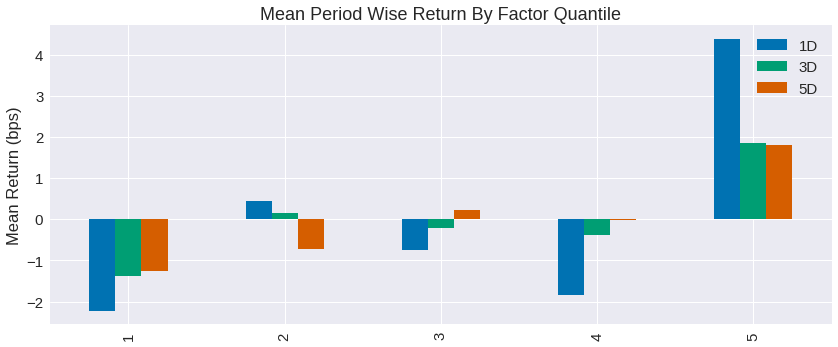

In [10]:
alphalens.tears.create_summary_tear_sheet(factor_data)

# Prepare data for Pyfolio

We can see in Alphalens analysis that quantiles 1 and 5 are the most predictive so we'll build a portfolio data using only those quantiles.

In [11]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(factor_data,
                                               period='1D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

Now that we have prepared the data we can run Pyfolio functions

Start date,2015-01-09
End date,2016-12-23
Total months,24
,Backtest
Annual return,8.3%
Cumulative returns,17.7%
Annual volatility,6.4%
Sharpe ratio,1.28
Calmar ratio,1.16
Stability,0.69
Max drawdown,-7.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.17,2016-03-31,2016-11-15,NaT,NaN
1,3.24,2015-02-05,2015-03-06,2015-04-08,45
2,3.15,2016-01-05,2016-01-20,2016-02-15,30
3,2.58,2015-09-04,2015-09-29,2015-10-22,35
4,1.99,2015-07-06,2015-08-24,2015-08-25,37


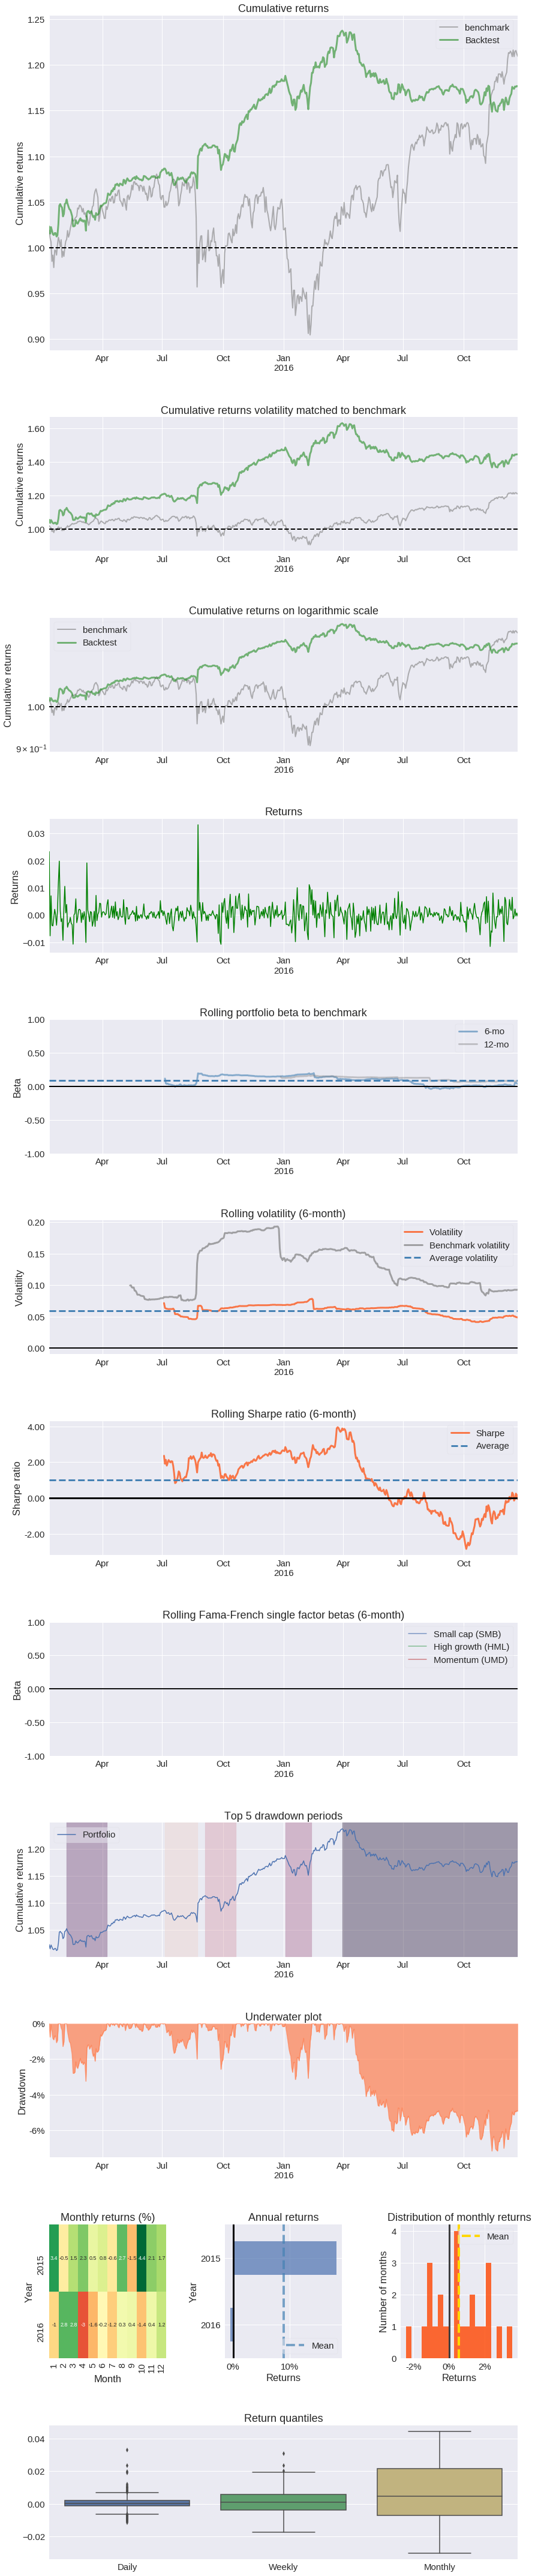

/home/lucasca/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Fall2015,0.02%,-1.07%,3.31%
New Normal,0.03%,-1.15%,3.31%


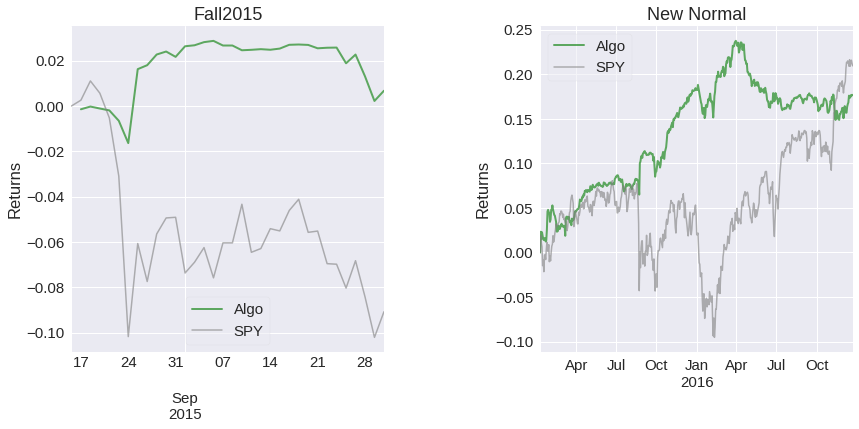

Top 10 long positions of all time,max
A,1.04%
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ACN,1.04%
ADBE,1.04%
ADI,1.04%
ADS,1.04%
AEE,1.04%


Top 10 short positions of all time,max
A,-1.04%
AAL,-1.04%
AAPL,-1.04%
ABBV,-1.04%
ABC,-1.04%
ABT,-1.04%
ACN,-1.04%
ADBE,-1.04%
ADI,-1.04%
ADS,-1.04%


Top 10 positions of all time,max
A,1.04%
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ABT,1.04%
ACN,1.04%
ADBE,1.04%
ADI,1.04%
ADS,1.04%


All positions ever held,max
A,1.04%
GOOG,1.04%
JNPR,1.04%
JPM,1.04%
KEY,1.04%
KLAC,1.04%
KSU,1.04%
L,1.04%
LH,1.04%
LLL,1.04%


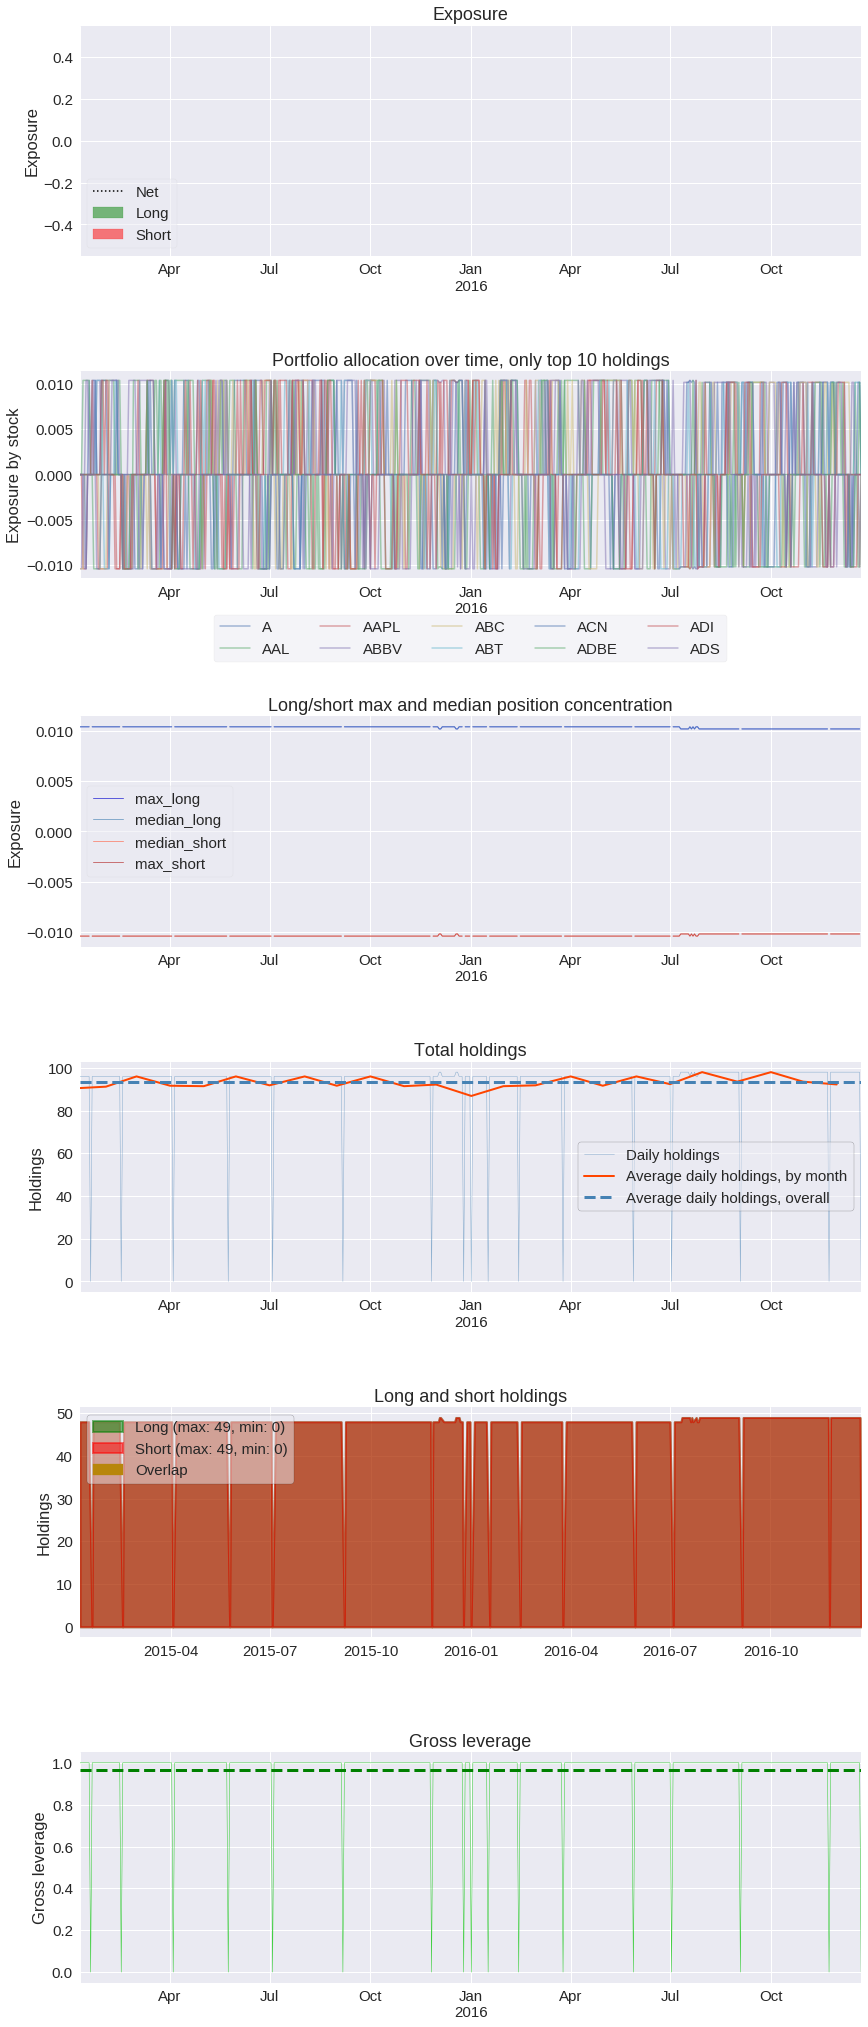

In [12]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)

## Analyzing subsets of data

Sometimes it might be useful to analyze subets of your factor data, for example it could be interesting to see the comparison of your factor in different days of the week. Below we'll see how to select and analyze factor data corresponding to Mondays, the positions will be held the for a period of 5 days

In [13]:
monday_factor_data = factor_data[ factor_data.index.get_level_values('date').weekday == 0 ]

In [14]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(monday_factor_data,
                                               period='5D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

/home/lucasca/dev/alphalens/empyrical/stats.py:821: RuntimeWarning: Mean of empty slice
  return nanmean(alpha_series) * ann_factor


Start date,2015-01-19
End date,2016-12-26
Total months,4
,Backtest
Annual return,15.5%
Cumulative returns,6.0%
Annual volatility,13.5%
Sharpe ratio,1.13
Calmar ratio,1.61
Stability,0.20
Max drawdown,-9.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.60,2015-12-28,2016-09-05,NaT,NaN
1,3.17,2015-02-09,2015-04-06,2015-06-22,96
2,2.34,2015-06-22,2015-08-24,2015-08-31,51
3,0.36,2015-10-05,2015-10-12,2015-10-19,11
4,0.26,2015-08-31,2015-09-07,2015-09-28,21


/home/lucasca/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


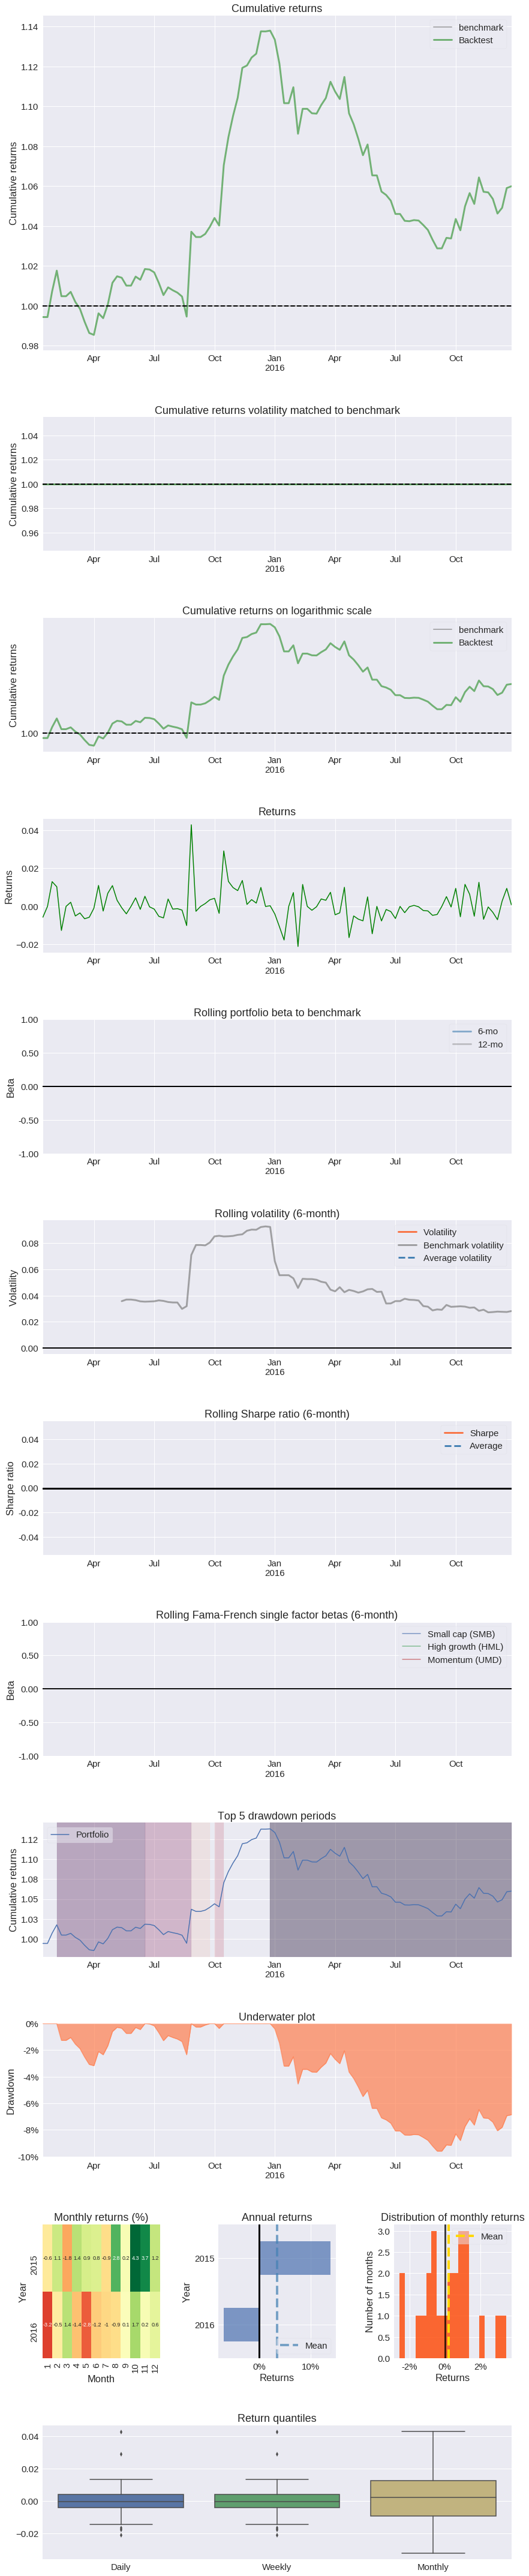

/home/lucasca/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Fall2015,0.47%,-1.00%,4.28%
New Normal,0.06%,-2.10%,4.28%


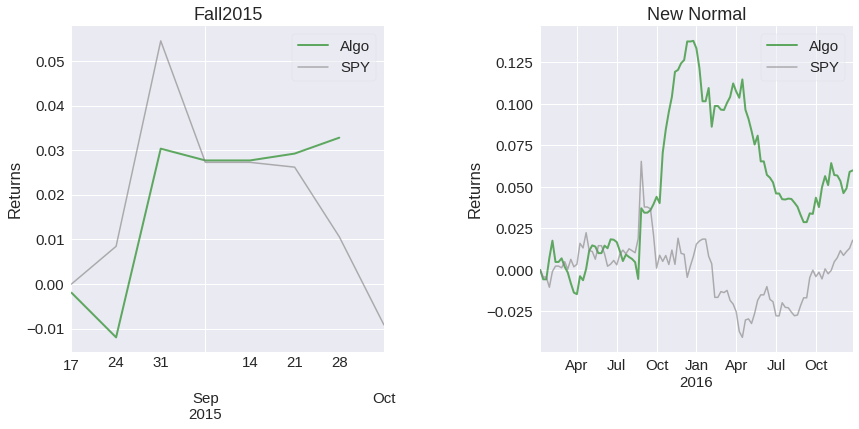

Top 10 long positions of all time,max
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ACN,1.04%
ADI,1.04%
ADS,1.04%
AEE,1.04%
AES,1.04%
AET,1.04%


Top 10 short positions of all time,max
AAL,-1.04%
AAPL,-1.04%
ABBV,-1.04%
ABC,-1.04%
ABT,-1.04%
ADBE,-1.04%
ADI,-1.04%
AEE,-1.04%
AEP,-1.04%
AES,-1.04%


Top 10 positions of all time,max
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ABT,1.04%
ACN,1.04%
ADBE,1.04%
ADI,1.04%
ADS,1.04%
AEE,1.04%


All positions ever held,max
XRAY,1.04%
JBHT,1.04%
ILMN,1.04%
INCY,1.04%
INFO,1.04%
INTC,1.04%
INTU,1.04%
IQV,1.04%
IR,1.04%
ISRG,1.04%


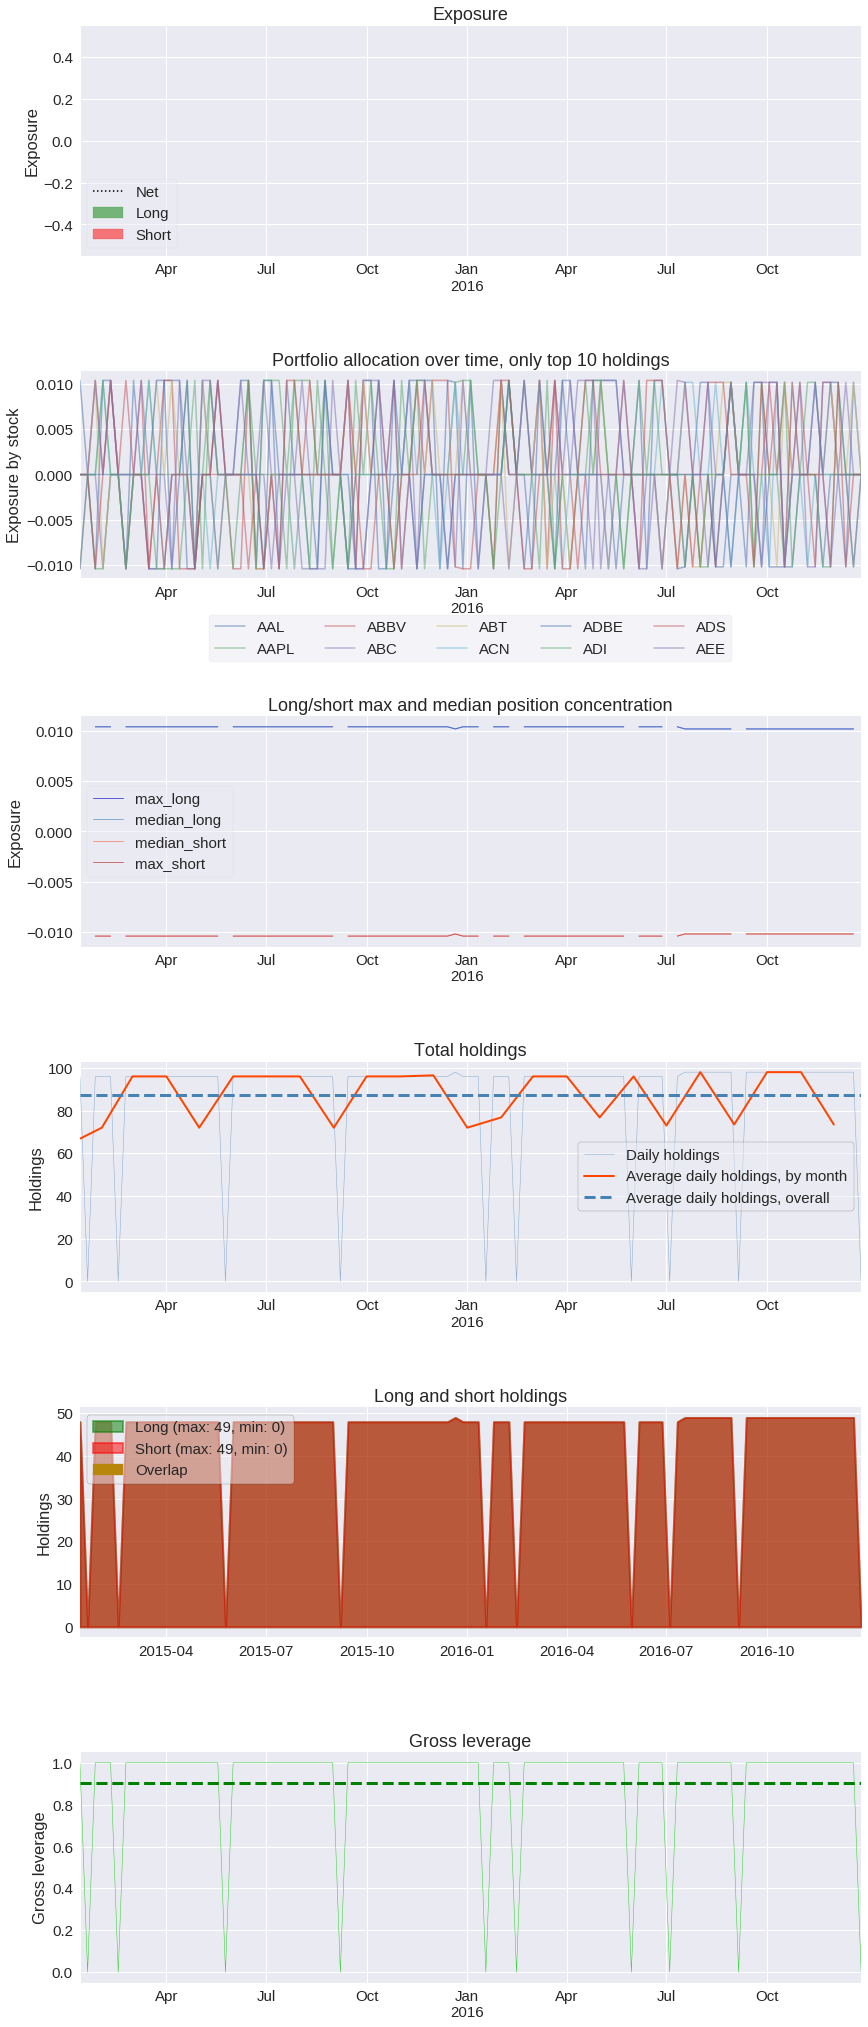

In [15]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)